# Data Acquisition. 0 Data Structure of Files

In [1]:
import missingno as msno

In [2]:
# all modules
import warnings
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import requests

import re

from datetime import datetime
from sklearn.preprocessing import OneHotEncoder

from zipfile import ZipFile
from bs4 import BeautifulSoup

In [3]:
# global stuff
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 25)

In [4]:
# load sql extension for jupyter
%load_ext sql
%config SqlMagic.autocommit = False

In [5]:
# load database
%sql sqlite:///../data/raw/raw_data_project_m1.db

In [6]:
%%sql tables_structure <<

select * 
from 
    sqlite_master

where 
    type='table' AND
    name NOT LIKE 'sqlite_%'


 * sqlite:///../data/raw/raw_data_project_m1.db
Done.
Returning data to local variable tables_structure


## OPENING TABLES

In [7]:
%%sql personal_info <<

select * from personal_info;

 * sqlite:///../data/raw/raw_data_project_m1.db
Done.
Returning data to local variable personal_info


In [8]:
df_personal_info = personal_info.DataFrame()
df_personal_info.shape

(9649, 5)

In [9]:
%%sql country_info <<

select * from country_info;

 * sqlite:///../data/raw/raw_data_project_m1.db
Done.
Returning data to local variable country_info


In [10]:
df_country_info = country_info.DataFrame()
df_country_info.shape

(9649, 3)

In [11]:
%%sql career_info <<

select * from career_info;

 * sqlite:///../data/raw/raw_data_project_m1.db
Done.
Returning data to local variable career_info


In [12]:
df_career_info = career_info.DataFrame()
df_career_info.shape

(9649, 4)

In [13]:
%%sql poll_info <<

select * from poll_info;

 * sqlite:///../data/raw/raw_data_project_m1.db
Done.
Returning data to local variable poll_info


In [14]:
df_poll_info = poll_info.DataFrame()
df_poll_info.shape

(9649, 6)

# WEB SCRAPPING

In [38]:
def get_dictCountries(web_page):
    """
    Note_1: Only works for a part of the web scrapping, therefore dict lenght is limited to countries_in_eu
    Note_2: 'https://ec.europa.eu/eurostat/statistics-explained/index.php/Glossary:Country_codes'
    ____
    
    INPUT: url
    OUTPUT: dict -> 'SP': 'Spain'

    """
    countries_in_europe = 45
        
    url= web_page
    html = requests.get(url).content

    soup = BeautifulSoup(html, 'lxml')
    table = soup.find_all('table',{class: 'wikitable sortable jquery-tablesorter'})[0]
    
    countries_list = list(filter(None, 
                                 [re.sub('\n','', re.sub('</td>','', re.sub('^<td>','', str(i)))) 
                                  for i in soup.find_all('td')]))

    """
    Note
    ----
    Esta parte es mejorable: Kosovo* y CH_X_HK etc ... 
    pero funciona para los 28 paises que tiene que funcionar!
    """
    countries_names = [(''.join(i.strip())).split('<')[0] for k, i in enumerate(countries_list) if k%2 == 0]
    countries_alpha2= [(''.join(i.strip())).split('<')[0][1:3] for k, i in enumerate(countries_list) if k%2 != 0]

    countries_dict = dict(zip(countries_alpha2[:countries_in_europe], countries_names[:countries_in_europe]))

    return countries_dict

In [39]:
countries_code_alpha_2 = get_dictCountries('https://ec.europa.eu/eurostat/statistics-explained/index.php/Glossary:Country_codes')
countries_code_iso_2 = get_dictCountries('https://en.wikipedia.org/wiki/ISO_3166-2')

In [40]:
# DICTIONARY TO REPLACE WITH WEB SCRAPPING

countries_code_alpha_2 = {
    'AT' : 'Austria',   'BE' : 'Belgium',        'BG' : 'Bulgaria',  'CY' : 'Cyprus',     'CZ' : 'Czechia',
    'DE' : 'Germany',   'DK' : 'Denmark',        'EE' : 'Estonia',   'ES' : 'Spain',      'FI' : 'Finland', 
    'FR' : 'France',    'GB' : 'United Kingdom', 'GR' : 'Greece',    'HR' : 'Croatia',    'HU' : 'Hungary', 
    'IE' : 'Ireland',   'IT' : 'Italy',          'LT' : 'Lithuania', 'LU' : 'Luxembourg', 'LV' : 'Latvia',  
    'MT' : 'Malta',     'NL' : 'Netherlands',    'PL' : 'Poland',    'PT' : 'Portugal',   'RO' : 'Romania',
    'SE' : 'Sweden',    'SI' : 'Slovenia',       'SK' : 'Slovakia',
} 
"""Hay 28 paises y me he sacado 45 de lap pag (TODA EUROPA) """ 

'Hay 28 paises y me he sacado 45 de lap pag (TODA EUROPA) '

In [49]:
countries_code_alpha_2

{'BE': 'Belgium',
 'EL': 'Greece',
 'LT': 'Lithuania',
 'PT': 'Portugal',
 'BG': 'Bulgaria',
 'ES': 'Spain',
 'LU': 'Luxembourg',
 'RO': 'Romania',
 'CZ': 'Czechia',
 'FR': 'France',
 'HU': 'Hungary',
 'SI': 'Slovenia',
 'DK': 'Denmark',
 'HR': 'Croatia',
 'MT': 'Malta',
 'SK': 'Slovakia',
 'DE': 'Germany',
 'IT': 'Italy',
 'NL': 'Netherlands',
 'FI': 'Finland',
 'EE': 'Estonia',
 'CY': 'Cyprus',
 'AT': 'Austria',
 'SE': 'Sweden',
 'IE': 'Ireland',
 'LV': 'Latvia',
 'PL': 'Poland',
 'UK': 'United Kingdom',
 'IS': 'Iceland',
 'NO': 'Norway',
 'LI': 'Liechtenstein',
 'CH': 'Switzerland',
 'ME': 'Montenegro',
 'MK': 'North Macedonia',
 'AL': 'Albania',
 'RS': 'Serbia',
 'TR': 'Turkey',
 'BA': 'Bosnia and Herzegovina',
 'XK': 'Kosovo*',
 'AM': 'Armenia',
 'BY': 'Belarus',
 'GE': 'Georgia',
 'AZ': 'Azerbaijan',
 'MD': 'Moldova',
 'UA': 'Ukraine'}

In [48]:
countries_code_alpha_2_bis

{'AT': 'Austria',
 'BE': 'Belgium',
 'BG': 'Bulgaria',
 'CY': 'Cyprus',
 'CZ': 'Czechia',
 'DE': 'Germany',
 'DK': 'Denmark',
 'EE': 'Estonia',
 'ES': 'Spain',
 'FI': 'Finland',
 'FR': 'France',
 'GB': 'United Kingdom',
 'GR': 'Greece',
 'HR': 'Croatia',
 'HU': 'Hungary',
 'IE': 'Ireland',
 'IT': 'Italy',
 'LT': 'Lithuania',
 'LU': 'Luxembourg',
 'LV': 'Latvia',
 'MT': 'Malta',
 'NL': 'Netherlands',
 'PL': 'Poland',
 'PT': 'Portugal',
 'RO': 'Romania',
 'SE': 'Sweden',
 'SI': 'Slovenia',
 'SK': 'Slovakia'}

# FUNCTIONS

In [43]:
def ageStr_to_ageNum(serie):
    """
    INPUT -> serie df[] = ['61 years old', '57 years old', '32 years old'] -> full strings
    OUPUT -> serie df[] = [ 61 57 32 45 41 1990 2000]                      -> only integers
    """
    return serie.apply(lambda x: re.sub('\D', '', x)).astype(int)

def year_to_age(serie):
    """
    INPUT -> serie:  df[] = [ 61 57 32 45 41 1990 2000]   -> ages + years (all ints)
    OUTPUT -> serie: df[] = [ 61 57 32 45 41   30   20]   -> only ages    (all ints)
    """   
    year_db = 2016 # DB is from this year!
    return serie.apply(lambda x: year_db - x if int(x) > 200 else x)

def year_update(serie):
    """
    La tabla está en 2016, hay que actualizar datos para uqe no haya incongruencias entre Age y Age_Group
    """
    year_now = datetime.today().year
    year_db = 2016
    return serie.apply(lambda x: (year_now - year_db) + x)


def countryCode_to_countryName(serie, web_page):
    """
    INPUT  ->      AT      FR     ES  -> alpha_2 code
    OUTPUT -> Austria  France  Spain  -> full name
    -----------
    Note: countries_code_alpha_2 is a dict from get_dictCountries()
    """
    url = web_page
    country_dictionary = get_dictCountries(url)
    
    return serie.apply(lambda x: country_dictionary[str(x)])


def null_to_unknown(serie):
    """
    INPUT  -> no  high     None  medium     None  low  no
    OUTPUT -> no  high  unknown  medium  unknown  low  no
    
    Podria considerarse tb no... aquí hay interpretación de datos!
    """
    return serie.apply(lambda x: 'unknown' if x == None else x)


def gender_homogenization(serie):
    """
    INPUT  -> female, FeMale, Fem, male, Male
    OUTPUT ->      F,      F,   F,    M,    M
    """
    serie = serie.apply(lambda x: re.sub('^f\w+|^F\w+', 'F', x))
    serie = serie.apply(lambda x: re.sub('^m\w+|^M\w+', 'M', x))
    return serie


def context_homogenization(serie):
    """
    INPUT  ->   urban  city  rural  Non-Rural Countryside  -> various types of response
    OUTPUT ->   urban  urban rural      urban       rural  -> two types of response
    LIST OF POSSIBLE ANSWERS TAKING INTO ACCOUNT serie count values
    """
    urban_context = ['urban', 'city', 'non-rural', 'Non-Rural']
    rural_context = ['rural', 'country', 'countryside', 'Country']
    
    return  ['urban_context' if response in urban_context 
        else 'rural_context' if response in rural_context 
        else None 
        for response in serie]



def yes_no_to_bool(serie):
    """
    Appliable to yes/no questions with multiple formats, to transform into boolean info
    INPUT  -> YES yes Yes yES No NO nO no  -> type str
    OUTPUT ->   1   1   1   1  0  0  0  0  -> type bool
    """
    serie = serie.apply(lambda x: re.sub('^y\w+|^Y\w+', '1', x))
    serie = serie.apply(lambda x: re.sub('^n\w+|^N\w+', '0', x)).astype(int)
    return serie.astype(bool)



################################################################################# EJERCICIO DE API ####

def get_job_code(serie):
    """
    In table career_info
    INPUT  -> hash
    OUTPUT -> dictionary w hash info provided by API
    """
    json_dicts = []
    uuid_db = serie.unique().tolist()
    
    for job_code in uuid_db:
        response = requests.get(f'http://api.dataatwork.org/v1/jobs/{job_code}')
        json_dicts.append(response.json())
        
    return json_dicts


def normalized_jobs_col(coded_series, json_data):
    """
    INPUT  -> None  <hash>                 --> coded_col
    OUTPUT -> None  <job name as in API>   --> new_col
    """
    new_col = [d.get('title')  for job_code in coded_series 
                               for d in json_data 
                               if d.get('uuid') == job_code]
    return new_col


################################################################################# SCKLEARN COSAS DE ML ####

def separate_df_to_bools(df, cols_to_separate, cols_separated):
    """
    INPUT  -> df[col].unique() = [range_1, range_2, range_3]
    OUTPUT -> df[[range_1, range_2, range_3]] with boolean responses
    """
    df_encoder = OneHotEncoder(dtype=bool, sparse=True)
    df = pd.DataFrame(df_encoder.fit_transform(df[cols_to_separate]).toarray(),columns=cols_separated)
    return df

### 1_ DF_PERSONAL_INFO

In [21]:
try:
    initial_cols = ['gender', 'age_group']
    final_cols = ['gender_Female', 'gender_Male', 'ageGroup_14_25', 'ageGroup_26_39', 'ageGroup_40_65', 'ageGroup_juvenile']
    
    # Paso 1_ normalización de columna Age: str -> int -> change years w/ ages -> update current year?
    df_personal_info['age'] = ageStr_to_ageNum(df_personal_info['age'])
    df_personal_info['age'] = year_to_age(df_personal_info['age'])
    # df_personal_info['age'] = year_update(df_personal_info['age'])
    """ El problema de actualizar la fecha es que hay que reevaluar los grupos de edad"""

    # Paso 2_ String Operations: multiple inputs in binomial cols -> only 2 values for 2 options
    df_personal_info['gender'] = gender_homogenization(df_personal_info['gender'])
    df_personal_info['dem_has_children'] = yes_no_to_bool(df_personal_info['dem_has_children'])
    
    # Paso 3_ Separate cols for boolean options
    new_bool_df = separate_df_to_bools(df_personal_info, initial_cols, final_cols)
    df_personal_info = df_personal_info.join(other= new_bool_df, on=None, how='left', sort=False)
    
except:
    print('Something went wrong')

finally:
    """ MEMORY USAGE from 377.0+ KB to 367.6+ KB | FROM object(5) to bool(7), object(4) """
    print('Done cleaning df_personal_info!')

Done cleaning df_personal_info!


In [22]:
df_personal_info.head(2)

,uuid,age,gender,dem_has_children,age_group,gender_Female,gender_Male,ageGroup_14_25,ageGroup_26_39,ageGroup_40_65,ageGroup_juvenile
0,f6e7ee00-deac-0133-4de8-0a81e8b09a82,61,M,False,40_65,False,True,False,False,True,False
1,54f0f1c0-dda1-0133-a559-0a81e8b09a82,57,M,True,40_65,False,True,False,False,True,False


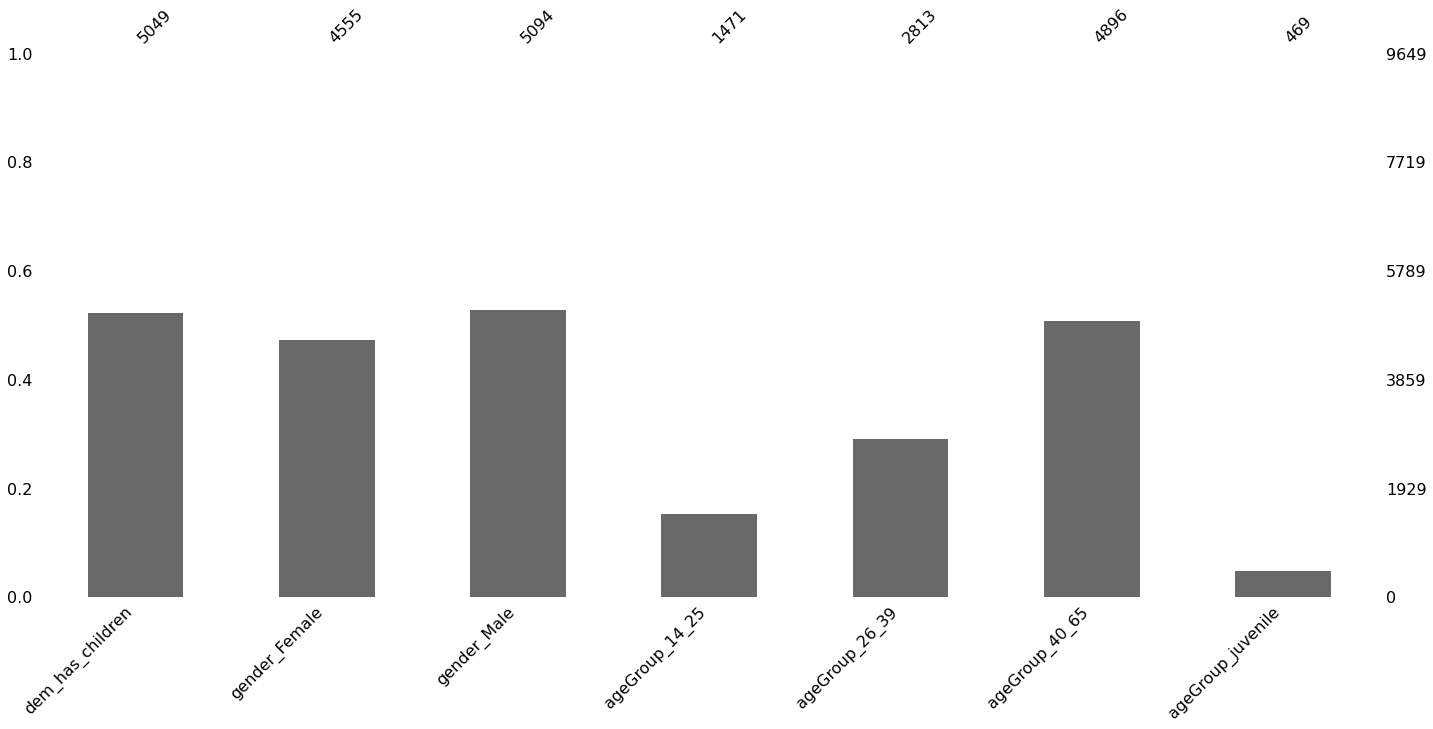

In [23]:
null_pattern = pd.DataFrame(df_personal_info[['dem_has_children', 'gender_Female', 'gender_Male', 'ageGroup_14_25', 'ageGroup_26_39', 'ageGroup_40_65', 'ageGroup_juvenile']]).replace({False: None})
msno.bar(null_pattern)

### 2_ DF COUNTRY_INFO 

In [47]:
for i in df_country_info['country_code']:
    print(countries_code_alpha_2[i])

Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria
Austria


KeyError: 'GB'

In [44]:
try:
    initial_cols = ['rural']
    final_cols = ['rural_context', 'urban_context']
    
    ### Here comes the dict from web scrapping
    
    # Paso 1_ transformar datos en cols en elementos más legibles
    df_country_info['country_Names_prueba'] = countryCode_to_countryName(
        serie= df_country_info['country_code'], 
        web_page= 'https://ec.europa.eu/eurostat/statistics-explained/index.php/Glossary:Country_codes')
    
    df_country_info['rural'] = context_homogenization(df_country_info['rural'])
    
    # Paso 2_
    new_bool_df = separate_df_to_bools(df_country_info, initial_cols, final_cols)
    
    df_country_info = df_country_info.join(other= new_bool_df, on=None, 
                                                               how='left', 
                                                               sort=False)

    df_country_info.drop(columns='rural', inplace = True)
    
except:
    pass

finally:
    """ MEMORY USAGE from 226.3+ KB to 169.70+ KB | FROM object(3) to bool(2), object(2) """
    print('Done cleaning df_country_info!')

Done cleaning df_country_info!


In [45]:
df_country_info.head(10)

,uuid,country_code,rural
0,f6e7ee00-deac-0133-4de8-0a81e8b09a82,AT,countryside
1,54f0f1c0-dda1-0133-a559-0a81e8b09a82,AT,urban
2,83127080-da3d-0133-c74f-0a81e8b09a82,AT,city
3,15626d40-db13-0133-ea5c-0a81e8b09a82,AT,Country
4,24954a70-db98-0133-4a64-0a81e8b09a82,AT,city
5,28583060-dbe2-0133-ff9c-0a81e8b09a82,AT,countryside
6,b50dbb80-da53-0133-8956-0a81e8b09a82,AT,urban
7,dd743bb0-d9a5-0133-53b2-0a81e8b09a82,AT,urban
8,4fde2370-da48-0133-3a42-0a81e8b09a82,AT,city
9,9949c4c0-da5f-0133-c832-0a81e8b09a82,AT,urban


### 3_ DF CAREER_INFO 

In [26]:
try:
    # Columnas a separar en booleanos
    initial_cols  = ['dem_education_level']
    final_cols = ['High_Ed', 'Low_Ed', 'Medium_Ed', 'No_Ed', 'Unknown_Ed']

    # Paso 1_ cambiar columnas de yes/no -> booleanos + Nones to Unknown en col de valores cualitativos
    df_career_info['dem_full_time_job'] = yes_no_to_bool(df_career_info['dem_full_time_job'])
    df_career_info['dem_education_level'] = null_to_unknown(df_career_info['dem_education_level'])
    
    # Paso 2_ A traves de API, añadir columna de nombres de JOBS
    json_job_data = get_job_code(df_career_info['normalized_job_code'])
    df_career_info['normalized_job_name'] = normalized_jobs_col(df_career_info['normalized_job_code'], json_job_data)
    
    # Paso 3_ Creación de nuevas columnas, a partir de columna inicial
    new_bool_df = separate_df_to_bools(df_career_info, initial_cols, final_cols)
    df_career_info = df_career_info.join(other= new_bool_df, on=None, how='left', sort=False)

    # Paso 4_ Eliminación de información redundante
    cols_to_del = ['dem_education_level', 'normalized_job_code']
    df_career_info.drop(columns= cols_to_del, inplace= True)
    
except:
    pass

finally:
    """MEMORY USAGE from 301.7+ KB to 207.4+ KB | FROM objects(4) to bool(6), object(2) """
    print('Done cleaning df_career_info!')

Done cleaning df_career_info!


In [27]:
df_career_info.head(20)

,uuid,dem_full_time_job,normalized_job_name,High_Ed,Low_Ed,Medium_Ed,No_Ed,Unknown_Ed
0,f6e7ee00-deac-0133-4de8-0a81e8b09a82,False,None,False,False,False,True,False
1,54f0f1c0-dda1-0133-a559-0a81e8b09a82,True,Automatic Data Processing Planner,True,False,False,False,False
2,83127080-da3d-0133-c74f-0a81e8b09a82,False,None,False,False,False,False,True
3,15626d40-db13-0133-ea5c-0a81e8b09a82,True,Data Coordinator,True,False,False,False,False
4,24954a70-db98-0133-4a64-0a81e8b09a82,True,Database Developer,True,False,False,False,False
5,28583060-dbe2-0133-ff9c-0a81e8b09a82,True,Data Entry Specialist,True,False,False,False,False
6,b50dbb80-da53-0133-8956-0a81e8b09a82,False,None,False,False,True,False,False
7,dd743bb0-d9a5-0133-53b2-0a81e8b09a82,True,Database Architect,False,False,True,False,False
8,4fde2370-da48-0133-3a42-0a81e8b09a82,True,Geographic Information Systems Database Admini...,False,False,True,False,False
9,9949c4c0-da5f-0133-c832-0a81e8b09a82,False,None,False,False,False,True,False


## 4_ DF POLL_INFO 

In [28]:
# df_poll_info.info()
""" dtypes: object(6) | memory usage: 452.4+ KB """

' dtypes: object(6) | memory usage: 452.4+ KB '

In [29]:
df_poll_info.describe().T

,count,unique,top,freq
uuid,9649,9649,fa0ccca0-d97a-0133-c59c-0a81e8b09a82,1
question_bbi_2016wave4_basicincome_awareness,9649,4,I know something about it,3389
question_bbi_2016wave4_basicincome_vote,9649,5,I would probably vote for it,3272
question_bbi_2016wave4_basicincome_effect,9649,9,A basic income would not affect my work choices,3349
question_bbi_2016wave4_basicincome_argumentsfor,9649,674,None of the above,2163
question_bbi_2016wave4_basicincome_argumentsagainst,9649,881,None of the above,1381


In [30]:
lista = list(np.sort(df_poll_info['question_bbi_2016wave4_basicincome_awareness'].unique()))
print(lista, type(lista))

['I have heard just a little about it', 'I have never heard of it', 'I know something about it', 'I understand it fully'] <class 'list'>


In [31]:
def split_str_at_char(str_to_split, cutter):
    if isinstance(str_to_split, str) and isinstance(cutter, str):
        return re.split(cutter, str_to_split)[1].capitalize()

In [32]:
df_poll_info['question_bbi_2016wave4_basicincome_effect'] = [split_str_at_char(response, 'Û_ ') 
                                                            if re.search('Û_ ', response)
                                                            else response
                                                            for response in df_poll_info['question_bbi_2016wave4_basicincome_effect']
                                                            ]
# revisar si se puede hacer con apply y comparar tiempos

In [33]:
# Esto se puede hacer en una funcion
responses_basic_income_awareness = list(np.sort(df_poll_info['question_bbi_2016wave4_basicincome_awareness'].unique()))
responses_basic_income_vote = list(np.sort(df_poll_info['question_bbi_2016wave4_basicincome_vote'].unique()))
responses_basic_income_effect = list(np.sort(df_poll_info['question_bbi_2016wave4_basicincome_effect'].unique()))

all_responses = responses_basic_income_awareness + responses_basic_income_vote + responses_basic_income_effect
initial_cols = ['question_bbi_2016wave4_basicincome_awareness', 'question_bbi_2016wave4_basicincome_vote', 'question_bbi_2016wave4_basicincome_effect']

In [34]:
new_bool_df = separate_df_to_bools(df_poll_info,\
                                   cols_to_separate= initial_cols,\
                                   cols_separated= all_responses)

df_poll_info = df_poll_info.join(other= new_bool_df, on=None, how='left', sort=False)

# df_poll_info.drop(columns=initial_cols, inplace= True)

In [35]:
df_poll_info.head(10)

,uuid,question_bbi_2016wave4_basicincome_awareness,question_bbi_2016wave4_basicincome_vote,question_bbi_2016wave4_basicincome_effect,question_bbi_2016wave4_basicincome_argumentsfor,question_bbi_2016wave4_basicincome_argumentsagainst,I have heard just a little about it,I have never heard of it,I know something about it,I understand it fully,I would not vote,I would probably vote against it,I would probably vote for it,I would vote against it,I would vote for it,A basic income would not affect my work choices,Do more volunteering work,Gain additional skills,Look for a different job,None of the above,Spend more time with my family,Stop working,Work as a freelancer,Work less
0,f6e7ee00-deac-0133-4de8-0a81e8b09a82,I know something about it,I would not vote,None of the above,None of the above,None of the above,False,False,True,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False
1,54f0f1c0-dda1-0133-a559-0a81e8b09a82,I understand it fully,I would probably vote for it,A basic income would not affect my work choices,It increases appreciation for household work a...,It might encourage people to stop working,False,False,False,True,False,False,True,False,False,True,False,False,False,False,False,False,False,False
2,83127080-da3d-0133-c74f-0a81e8b09a82,I have heard just a little about it,I would not vote,Gain additional skills,It creates more equality of opportunity,Foreigners might come to my country and take a...,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False
3,15626d40-db13-0133-ea5c-0a81e8b09a82,I have heard just a little about it,I would probably vote for it,Work less,It reduces anxiety about financing basic needs,None of the above,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True
4,24954a70-db98-0133-4a64-0a81e8b09a82,I have heard just a little about it,I would probably vote for it,None of the above,It reduces anxiety about financing basic needs,It is impossible to finance | It might encoura...,True,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False
5,28583060-dbe2-0133-ff9c-0a81e8b09a82,I understand it fully,I would vote against it,A basic income would not affect my work choices,It encourages financial independence and self-...,It is impossible to finance | It might encoura...,False,False,False,True,False,False,False,True,False,True,False,False,False,False,False,False,False,False
6,b50dbb80-da53-0133-8956-0a81e8b09a82,I know something about it,I would probably vote for it,Work as a freelancer,It reduces anxiety about financing basic needs,Foreigners might come to my country and take a...,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False
7,dd743bb0-d9a5-0133-53b2-0a81e8b09a82,I know something about it,I would probably vote for it,A basic income would not affect my work choices,It increases appreciation for household work a...,It might encourage people to stop working | Fo...,False,False,True,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False
8,4fde2370-da48-0133-3a42-0a81e8b09a82,I have heard just a little about it,I would probably vote for it,None of the above,It creates more equality of opportunity | It r...,Foreigners might come to my country and take a...,True,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False
9,9949c4c0-da5f-0133-c832-0a81e8b09a82,I understand it fully,I would vote for it,Do more volunteering work,"It increases solidarity, because it is funded ...",Foreigners might come to my country and take a...,False,False,False,True,False,False,False,False,True,False,True,False,False,False,False,False,False,False


In [36]:
for item in df_poll_info['question_bbi_2016wave4_basicincome_argumentsfor'].unique():
    print(f'{item}\n')
    
"""Es una pregunta donde se puede elegir un núm de posibilidades"""

None of the above

It increases appreciation for household work and volunteering | It encourages financial independence and self-responsibility | It reduces anxiety about financing basic needs

It creates more equality of opportunity

It reduces anxiety about financing basic needs

It encourages financial independence and self-responsibility | It reduces anxiety about financing basic needs

It increases appreciation for household work and volunteering | It reduces anxiety about financing basic needs

It creates more equality of opportunity | It reduces anxiety about financing basic needs | It reduces bureaucracy and administrative expenses

It increases solidarity, because it is funded by everyone

It increases appreciation for household work and volunteering

It reduces anxiety about financing basic needs | It creates more equality of opportunity | It encourages financial independence and self-responsibility | It increases appreciation for household work and volunteering

It encourage

'Es una pregunta donde se puede elegir un núm de posibilidades'

In [37]:
for item in df_poll_info['question_bbi_2016wave4_basicincome_argumentsagainst'].unique():
    print(f'{item}\n')

None of the above

It might encourage people to stop working

Foreigners might come to my country and take advantage of the benefit

It is impossible to finance | It might encourage people to stop working | It increases dependence on the state

It is impossible to finance | It might encourage people to stop working | It is against the principle of linking merit and reward

Foreigners might come to my country and take advantage of the benefit | It might encourage people to stop working | It increases dependence on the state

It might encourage people to stop working | Foreigners might come to my country and take advantage of the benefit | It is impossible to finance | Only the people who need it most should get something from the state

Foreigners might come to my country and take advantage of the benefit | It is impossible to finance

It is against the principle of linking merit and reward | It might encourage people to stop working | It increases dependence on the state

Foreigners mi

Las cols anteriores se deberían separar en opciones y hacer una matriz de True o False, de esta forma se multiplicidad de opciones tendría sentido

## WEB SCRAPPING

In [207]:
url= 'https://laendercode.net/es/2-letter-list.html'
html = requests.get(url).content

soup = BeautifulSoup(html, 'lxml')
table = soup.find_all('table', {'class':'table table-colored table-hover'})

In [208]:
country_isoCodes = soup.find_all('h4', {'class': 'margin-clear'})
country_isoCodes_parsed = [code.text for code in country_isoCodes]

In [212]:
country_isoCodes_parsed[0:5]

['AF', 'AX', 'AL', 'DZ', 'AS']

In [214]:
country_fullNames_parsed = []

for code in country_isoCodes_parsed:
    cd = code.lower()
    url_firstHalf = 'https://laendercode.net/es/country/'    
    url_complete = url_firstHalf + str(cd)
    
    country_fullNames += soup.find_all('a', {'href': url_complete})

    """
    for i in soup.find_all('a'):
        del i['href']

    for i in soup.find_all('span'):
        del i['class']
    """
    
    print(country_fullNames)
    # country_fullNames_parsed = [fullName.text for fullName in country_fullNames]

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


In [205]:
country_fullNames_parsed[0:10]

[]

In [210]:
country_isoCodes_parsed[0:10]

['AF', 'AX', 'AL', 'DZ', 'AS', 'AD', 'AO', 'AI', 'AQ', 'AG']

In [199]:
country_fullNames_parsed[0:10]

['Afganistán',
 'Islas de Åland',
 'Albania',
 'Argelia',
 'Samoa Americana',
 'Andorra',
 'Angola',
 'Anguila',
 'Antártida',
 'Antigua y Barbuda']

In [200]:
countries_dict = dict(zip(country_isoCodes_parsed, country_fullNames_parsed))

In [201]:
countries_dict

{'AF': 'Afganistán',
 'AX': 'Islas de Åland',
 'AL': 'Albania',
 'DZ': 'Argelia',
 'AS': 'Samoa Americana',
 'AD': 'Andorra',
 'AO': 'Angola',
 'AI': 'Anguila',
 'AQ': 'Antártida',
 'AG': 'Antigua y Barbuda',
 'AR': 'Argentina',
 'AM': 'Armenia',
 'AW': 'Aruba',
 'AU': 'Australia',
 'AT': 'Austria',
 'AZ': 'Azerbaiyán',
 'BS': 'Bahamas',
 'BH': 'Baréin',
 'BD': 'Bangladesh',
 'BB': 'Bangladesh',
 'BY': 'Barbados',
 'BE': 'Bielorrusia',
 'BZ': 'Bélgica',
 'BJ': 'Belice',
 'BM': 'Benín',
 'BT': 'Bermuda',
 'BO': 'Bután',
 'BQ': 'Bolivia',
 'BA': 'Bonaire, San Eustaquio y Saba ',
 'BW': 'Bosnia y Herzegovina',
 'BV': 'Botsuana',
 'BR': 'Isla Bouvet',
 'IO': 'Brasil',
 'VG': 'Brasil',
 'BN': 'Territorio Británico del Océano Índico',
 'BG': 'Islas Vírgenes Británicas',
 'BF': 'Brunei',
 'BI': 'Bulgaria',
 'KH': 'Burkina Faso',
 'CM': 'Burundi',
 'CA': 'Camboya',
 'CV': 'Camerún',
 'KY': 'Canadá',
 'CF': 'Cabo Verde',
 'TD': 'Islas Caimán',
 'CL': 'República de África Central',
 'CN': 'Chad'